In [2]:
# Import Libraries
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf, os, datetime
import tensorflow_probability as tfp

tfd = tfp.distributions

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint#, TensorBoard                                                                      
from keras import backend as K
from livelossplot import PlotLossesKeras

#from tensorboard.plugins.hparams import api as hp                                                                             
#from keras.utils.generic_utils import get_custom_objects                                                                      

import gc
gc.enable()

In [1]:
ls -lrt 

total 54690096
-rw-r--r--@  1 tashaleebillings  staff      9733350 Jul  7  2020 filter_vis.ipynb
-rw-r--r--   1 tashaleebillings  staff      3077544 Jul  7  2020 Meeting_03_13_2020.ipynb
drwxr-xr-x@  6 tashaleebillings  staff          192 Jul 11  2020 learning/
-rw-r--r--   1 tashaleebillings  staff     82000524 Sep 23 15:54 toy_models_32x32.npz
-rw-r--r--   1 tashaleebillings  staff        24387 Oct 11 16:22 Bayesian_Toy_Model.ipynb
-rw-r--r--   1 tashaleebillings  staff      2623533 Oct 13 08:41 Bayesian_Toy_Model_1.ipynb
drwxr-xr-x@ 29 tashaleebillings  staff          928 Oct 25 16:55 toy_model_tuner/
-rw-r--r--   1 tashaleebillings  staff       157960 Oct 25 16:56 hyperParam_weights_5.h5
-rw-r--r--   1 tashaleebillings  staff       495008 Oct 25 16:56 hyperParam_model_5.h5
-rw-r--r--   1 tashaleebillings  staff       468208 Oct 25 16:56 hyperParam_weights_6.h5
-rw-r--r--   1 tashaleebillings  staff      1425984 Oct 25 16:56 hyperParam_model_6.h5
-rw-r--r--   1 tashaleebillings  sta

In [3]:
toy_model = np.load('toy_models_32x32.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']
outputdir = "./"

HP_EPOCH = 15
HP_BATCH_SIZE = 5
factor = 100

In [4]:
# Data Preprocessing                                                                                                                  
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1) / 255.0
X_test = X_test.reshape(10000, 28, 28, 1) / 255.0
X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

NUM_TRAIN_EXAMPLES = len(training_data)
kl_divergence_function = (
lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES,dtype=tf.float32)
)

training (8000, 32, 32, 1)
validation (2000, 32, 32, 1)


In [5]:
# Custom Loss Functions                                                                                                               
kl_divergence = tf.keras.losses.KLDivergence()

neg_log_likelihood = lambda y_true, y_pred: -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))

def Mean_Squared_over_true_Error(y_true, y_pred):
    # Create a custom loss function that divides the difference by the true                                                           

    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.                                        
    diff_ratio = K.square((y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None))

    loss = K.mean(diff_ratio, axis=-1)

    # Return a tensor                                                                                                                 
    return loss

def elbo(y_true, y_pred):
    kl_weight = 1
    neg_log_likelihood = -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))
    kl_divergence = tf.keras.losses.KLDivergence()

    elbo_loss = -tf.math.reduce_mean(-kl_weight * kl_divergence(y_true, y_pred.mean()) - neg_log_likelihood)
    # Return a tensor                                                                                                                 
    return elbo_loss

def mean_fractional_error(y_true, y_pred):
    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.
    diff_ratio = (y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None)
    loss = K.mean(diff_ratio, axis=-1)
    
    return loss
    

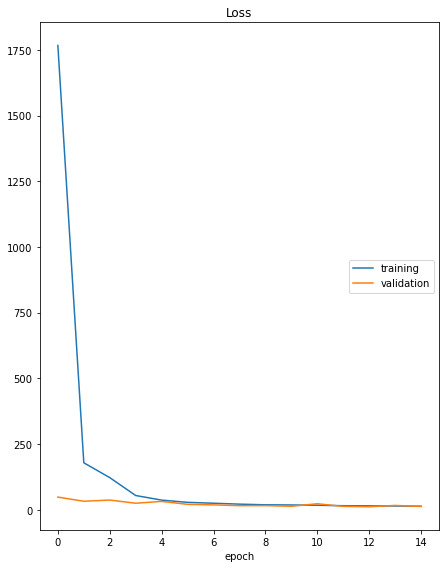

Loss
	training         	 (min:   13.579, max: 1766.481, cur:   13.579)
	validation       	 (min:   11.607, max:   48.289, cur:   12.661)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_6 (Conv2DFlip (None, 32, 32, 64)        1216      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_flipout_7 (Conv2DFlip (None, 16, 16, 32)        36896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)    

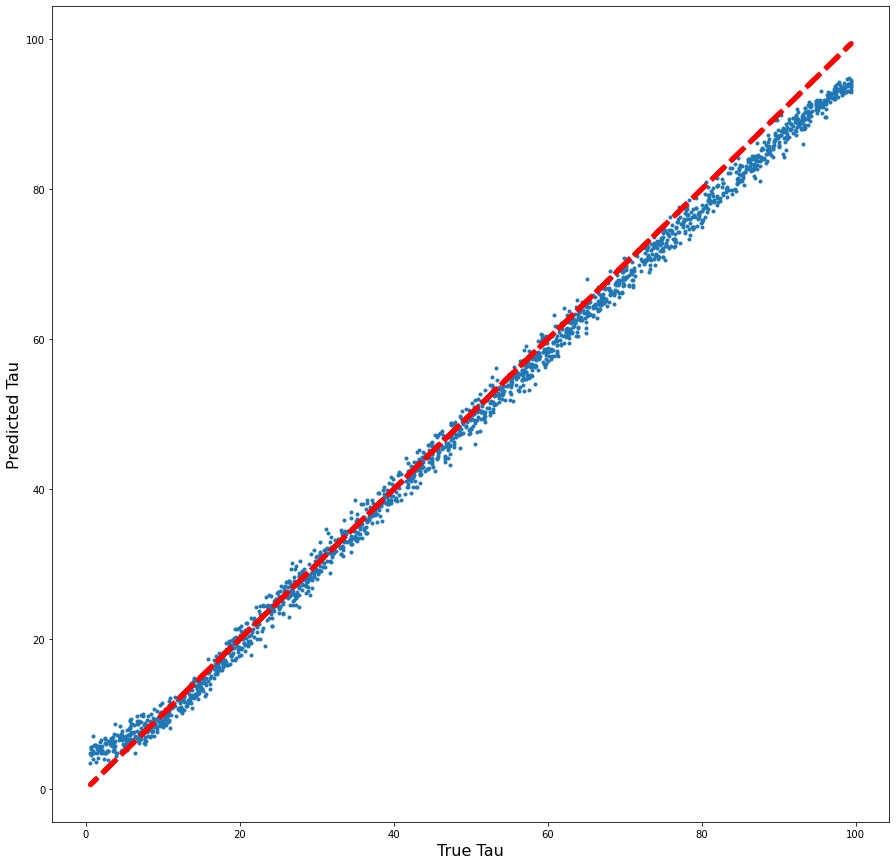

In [8]:
def train_test_model():
    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(64, input_shape=(nx, ny, 1), 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(32, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(16, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(8, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(4, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    model.compile(optimizer= "adam", loss = "mse", metrics=[])#neg_log_likelihood)#"mse")#"mape")                                                                                                      

    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

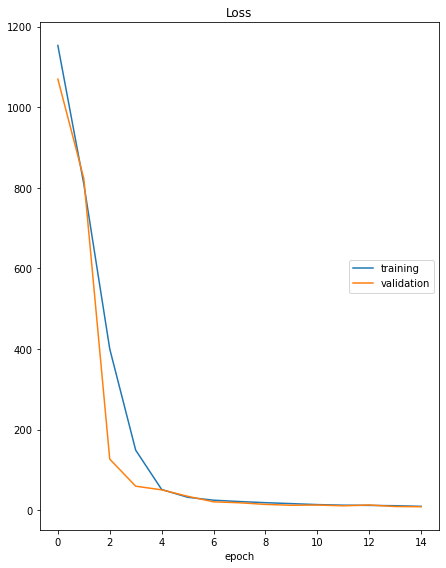

Loss
	training         	 (min:    9.398, max: 1153.199, cur:    9.398)
	validation       	 (min:    8.429, max: 1069.718, cur:    8.429)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_11 (Conv2DFli (None, 32, 32, 16)        304       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 16, 16, 8)         264       
_________________________________________________________________
conv2d_flipout_12 (Conv2DFli (None, 16, 16, 8)         1160      
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 8)   

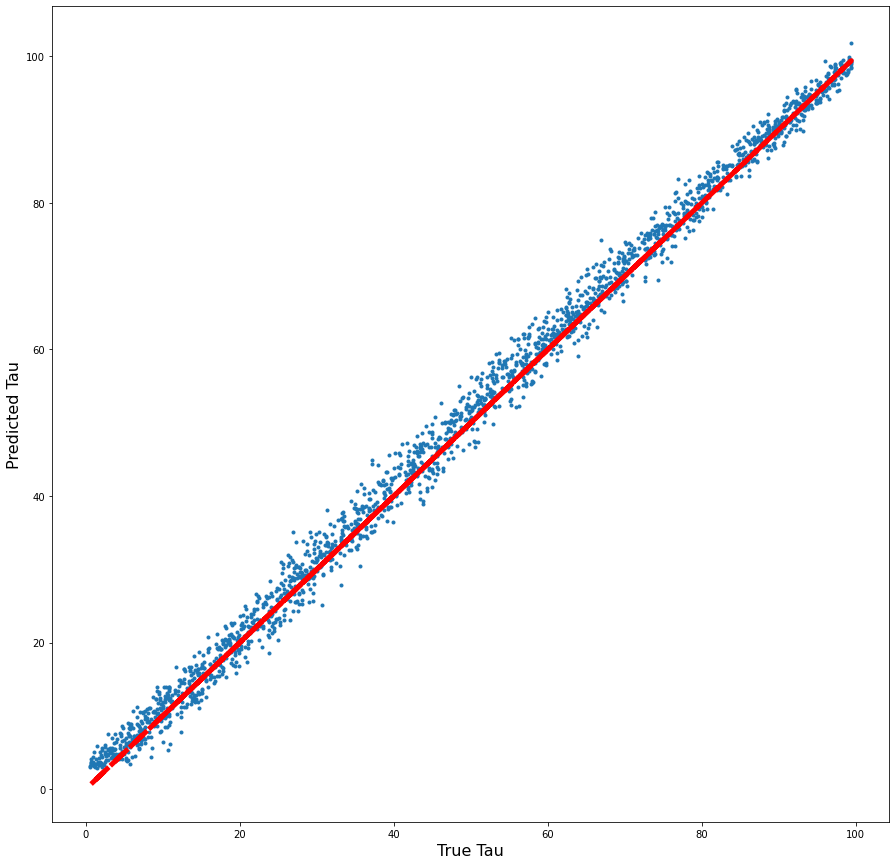

In [10]:
def train_test_model():
    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.DenseFlipout(8, activation='relu', kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(8, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(4, activation='relu', kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(4, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(2, activation='relu', kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(2, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(4, activation='relu', kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(4, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(2, activation='relu', kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(2, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(1, activation='relu', kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(1, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(1, 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    model.compile(optimizer= "adam", loss = "mse", metrics=[])#neg_log_likelihood)#"mse")#"mape")                                                                                                      

    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

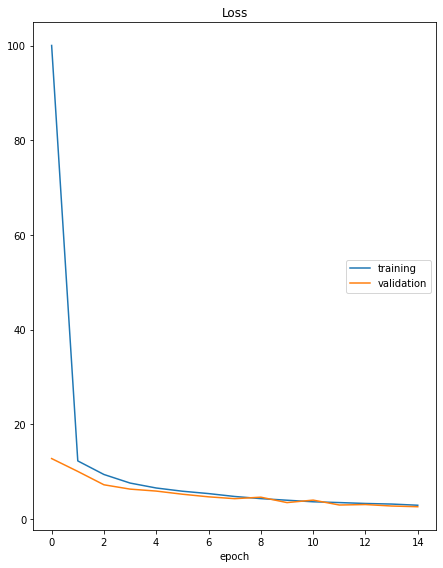

Loss
	training         	 (min:    2.880, max:  100.033, cur:    2.880)
	validation       	 (min:    2.564, max:   12.744, cur:    2.564)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_49 (Conv2DFli (None, 30, 30, 16)        304       
_________________________________________________________________
conv2d_flipout_50 (Conv2DFli (None, 30, 30, 8)         2312      
_________________________________________________________________
flatten_30 (Flatten)         (None, 7200)              0         
_________________________________________________________________
dense_flipout_43 (DenseFlipo (None, 1)                 14401     
Total params: 17,017
Trainable params: 17,017
Non-trainable params: 0
_________________________________________________________________
None
63/63 [==============================] - 1s 7ms/step - loss: 2.5755
(2000, 32, 32, 1)
(2000,)
(2000,)


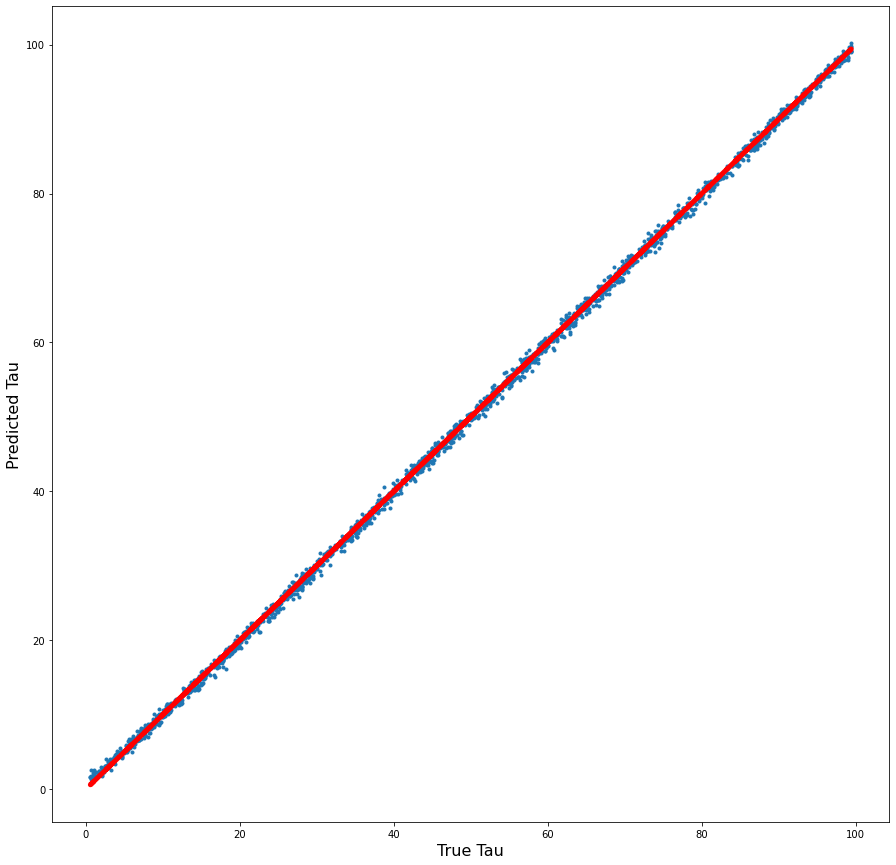

In [45]:
def train_test_model():
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    #model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1))) # was 64
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'))#, padding = 'same'))
    #model.add(Conv2D(8, kernel_size=3, activation="relu")) # was 32
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(Flatten())
    #model.add(Dense(1, activation="linear"))
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    #model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))
                                                                                                        

    model.compile(optimizer= "adam", loss = "mse", metrics=[])#neg_log_likelihood)#"mse")#"mape")                                                                                                      

    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

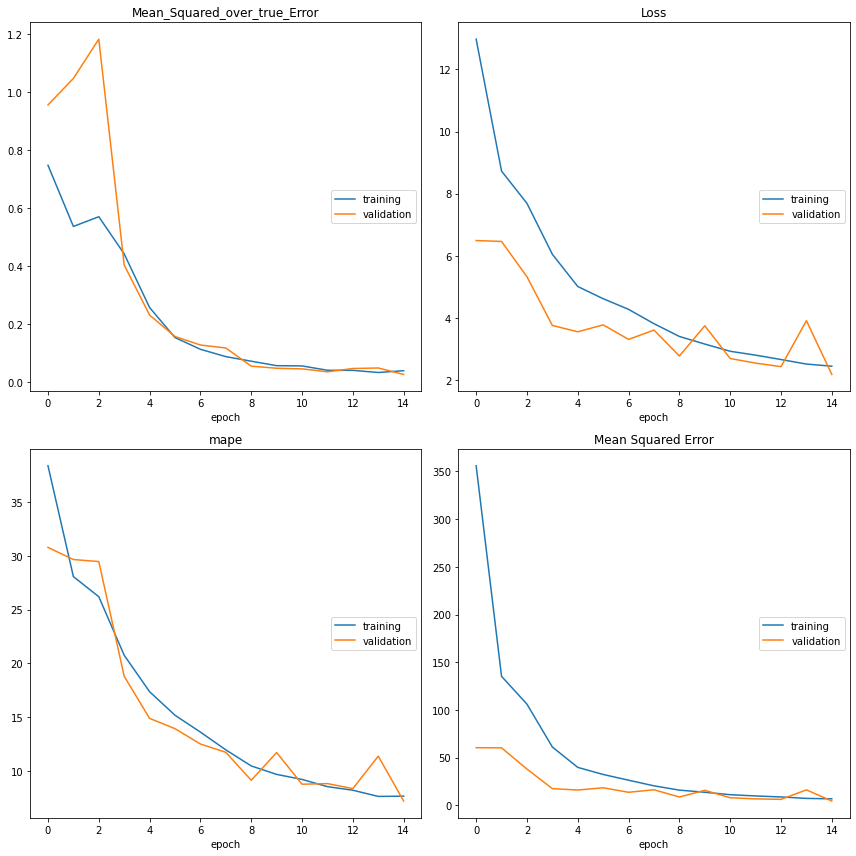

Mean_Squared_over_true_Error
	training         	 (min:    0.033, max:    0.748, cur:    0.039)
	validation       	 (min:    0.026, max:    1.183, cur:    0.026)
Loss
	training         	 (min:    2.446, max:   12.975, cur:    2.446)
	validation       	 (min:    2.181, max:    6.492, cur:    2.181)
mape
	training         	 (min:    7.624, max:   38.379, cur:    7.646)
	validation       	 (min:    7.194, max:   30.786, cur:    7.194)
Mean Squared Error
	training         	 (min:    6.744, max:  355.989, cur:    6.744)
	validation       	 (min:    4.416, max:   60.365, cur:    4.416)
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_53 (Conv2DFli (None, 30, 30, 16)        304       
_________________________________________________________________
batch_normalization_44 (Batc (None, 30, 30, 16)        64        
_____________________________________________________________

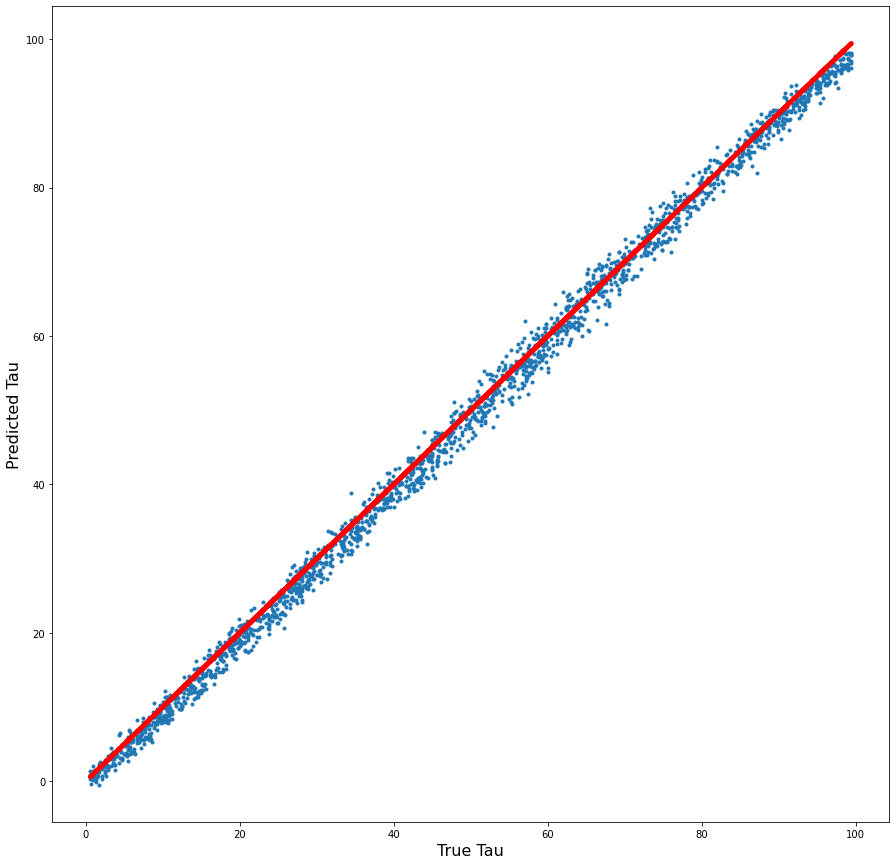

In [49]:
def train_test_model():
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'))#, padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    #model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))
                                                                                                        

    model.compile(optimizer= "adam", loss = "mae", metrics=["mse", "mape", Mean_Squared_over_true_Error])#neg_log_likelihood)#"mse")#"mape")                                                                                                      

    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

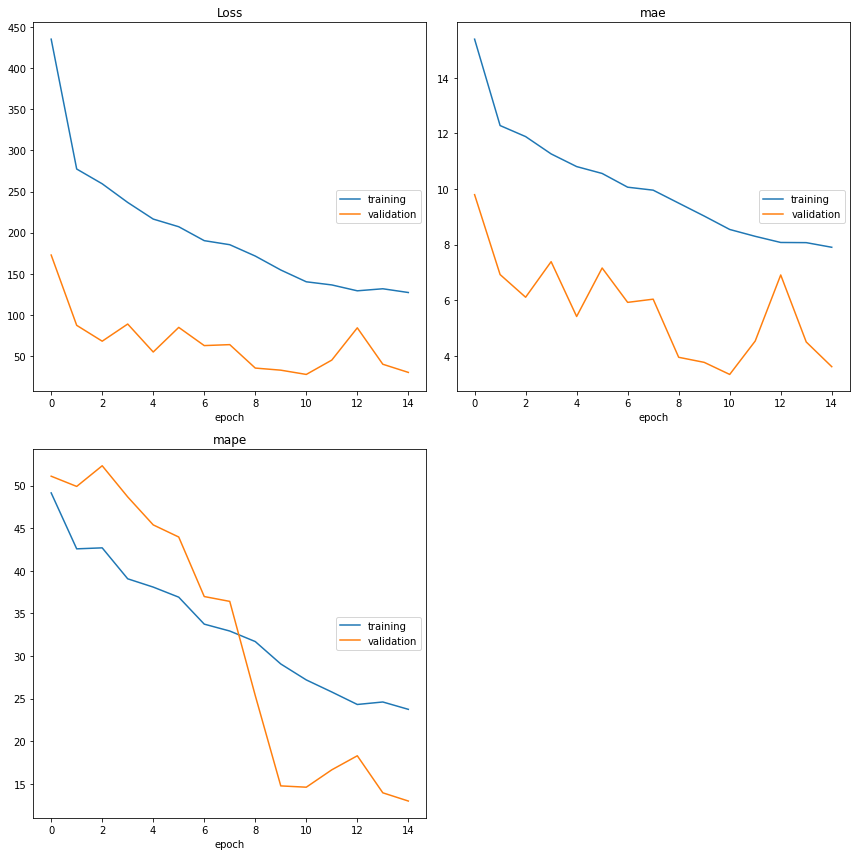

Loss
	training         	 (min:  127.318, max:  435.165, cur:  127.318)
	validation       	 (min:   27.773, max:  172.858, cur:   30.243)
mae
	training         	 (min:    7.903, max:   15.386, cur:    7.903)
	validation       	 (min:    3.331, max:    9.795, cur:    3.610)
mape
	training         	 (min:   23.739, max:   49.150, cur:   23.739)
	validation       	 (min:   12.973, max:   52.337, cur:   12.973)
63/63 [==============================] - 2s 9ms/step - loss: 30.9209 - mae: 3.7014 - mape: 13.0988
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_37 (Conv2DFli (None, 30, 30, 16)        304       
_________________________________________________________________
batch_normalization_34 (Batc (None, 30, 30, 16)        64        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 15, 15, 16)        0         
______

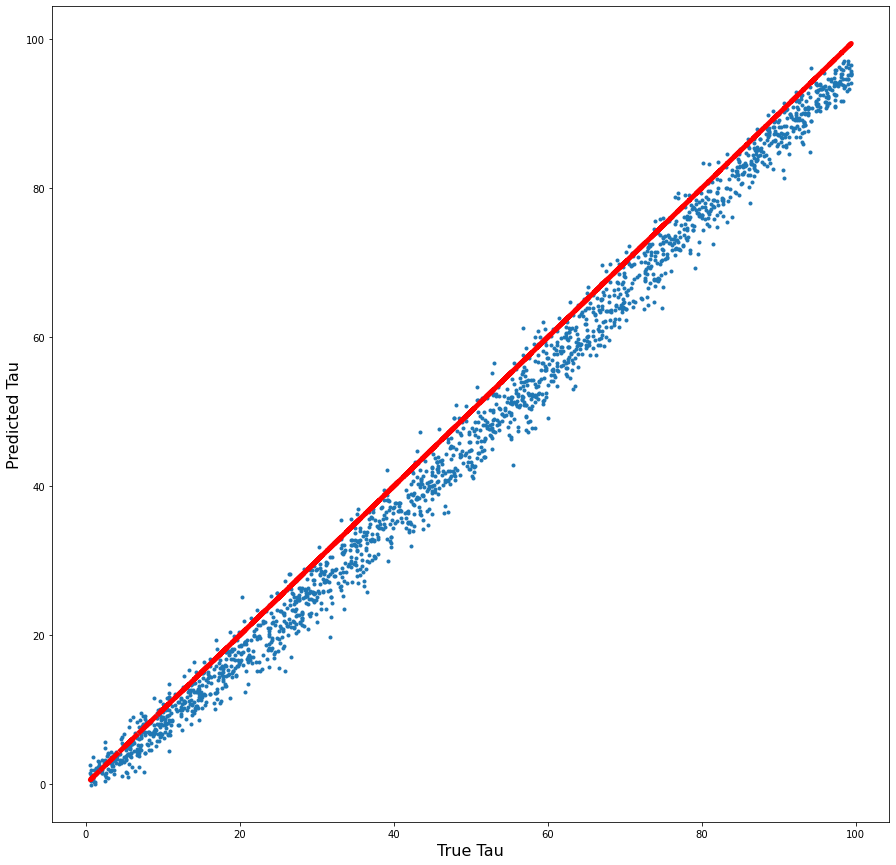

In [39]:
def train_test_model():
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(16, input_shape=(nx, ny, 1), 
                                              kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'))#, padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tfp.layers.Convolution2DFlipout(8, kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    
    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(100, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(10, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    #model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))
                                                                                                        

    model.compile(optimizer= "adam", loss = "mse", metrics=["mae", "mape", Mean_Squared_over_true_Error])#neg_log_likelihood)#"mse")#"mape")                                                                                                      

    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)

    loss = model.evaluate(X_test, y_test)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model
                                                                                                                                                                                      
model = train_test_model()

# make predictions                                                                                                                                                                      
predictions = []
for i in range(10):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
predictions = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.plot(y_test, predictions, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)